# Project 2 - Shelter Animal Outcomes


## Submitted by: Dror Vered

### August 2018

The goal of this project is to predict the outcome of the dogs and the cats as they leave the Austin Animal Center.
These outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer.

### Part 2:
Run machine learning models to predict the required outcome

-----------------------------------------------------------------------------------------------------------------------------

### My Work Plan:

- Apply data-related and model-related pre-processing steps as necessary (several rounds)
- Apply several relevant models
- Present final (best) results

In [759]:
import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
from sklearn import neighbors, linear_model
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, BaggingClassifier, \
                             AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# loading the outcomes DF, as saved in Part1 of the project
import pickle

In [3]:
with open('part1outcomes', 'rb') as f:
    outcomes = pickle.load(f)

In [319]:
# outcomes.head()

In [35]:
# outcomes.info()

## 1. Pre-processing steps

### 1.1. Feature Selection (round I)

As seen in Part 1 of the project, some of the features in the given data set are not relevant for the predictive models. 
These features are: 
- **Name:** The pet's name is not relevant. However, the 'Named' feature that I've added to the df will be in use
- **DateTime:** As this is the *outcome* date, this feature cannot help us with predicting the outcome type
- **OutcomeSubtype:** In part 1 of the project I showed some interesting findings regarding this feature, however it is not relevant for the predictive models
- **SexuponOutcome:** Instead of this feature, I've created two separate features (Sex and NeuterStatus) which will be in use here
- **AgeuponOutcome:** Instead of this feature, I've created the LifeStage feature, which I'll use here
- **Breed:** Instead of this feature, I've created several other features which I'll use here (BreedPurity, MainBreed, DogFamily) 
- **Color:** Instead of this feature, I've created two separate features (ColorCoat and ColorGroup) which will be in use here

In addition, some of the features that I've added in part 1, while investigating the data, are not relevant for this part of the project. These feature are: **DayOfWeek**, **Quarter** and **Holiday**.

**The features mentioned above will be dropped from the data set that will serve the predictive models.**

Note: Although I couldn't identify specific insights regarding 'lowBarking' and 'toleratesCold' features,  I choose not to drop them for now.


In [737]:
outcomes2 = outcomes.drop(columns=
       ['Name','DateTime','OutcomeSubtype','SexuponOutcome','AgeuponOutcome','Breed','Color','DayOfWeek','Quarter','Holiday'])

In [392]:
# outcomes2.shape

In [393]:
# outcomes2.info()

### 1.2. Preparing the data

In [738]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType

In [739]:
X = pd.get_dummies(X)

In [415]:
# X.head()

The given *test.csv* file is not useful, as it doesn't contains the OutcomeType feature. Therefore I will split the outcome DF to train/test.

In [740]:
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

## 2. Naive classification

## 2.1. Decision Tree model (as a start)

In [745]:
DT_clf = DecisionTreeClassifier(max_depth=20, min_samples_split=100, min_samples_leaf=100)
DT_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [746]:
print('Train:', DT_clf.score(X_train, y_train))
print('Test: ', DT_clf.score(X_test, y_test))

Train: 0.6526180670695834
Test:  0.6396306463688545


In [400]:
# Exporting the Tree
export_graphviz(decision_tree=DT_clf, out_file='outcomes_tree.dot', feature_names=X.columns, class_names=DT_clf.classes_,
                leaves_parallel=True, filled=True, rotate=False, rounded=True)

### 2.1.1. Adding data scaling

In [401]:
norm_scaler = StandardScaler()
X_train_scaled = norm_scaler.fit_transform(X_train)

DT_clf.fit(X_train_scaled, y_train)
print(DT_clf.score(X_train_scaled, y_train))

X_test_scaled = norm_scaler.transform(X_test)
print(DT_clf.score(X_test_scaled, y_test))

0.6526180670695834
0.6396306463688545


### 2.1.2. With PCA

In [402]:
pca_transformer = PCA(20)
X_train_scaled_pca = pca_transformer.fit_transform(X_train_scaled)
                                                   
DT_clf.fit(X_train_scaled_pca, y_train)
print(DT_clf.score(X_train_scaled_pca, y_train))
                                                   
X_test_scaled_pca = pca_transformer.transform(X_test_scaled)
print(DT_clf.score(X_test_scaled_pca, y_test))

0.6350216612290742
0.6071874220114799


## 2.2. Separating Dogs/Cats (investigation)

To check if the features that I've created and added in Part1 of the project are useful (at all), I will now try to apply them separately on Dogs and Cats. If the results are significantly better than above, then I'll try to improve the complete data set using more pre-processing steps.

**Dogs**

In [403]:
dog_columns = [col for col in list(outcomes2.columns) if 'Dog' in col]

outcomes2_Dogs = outcomes2[outcomes2.AnimalType == 'Dog']
outcomes2_Dogs.drop(columns='AnimalType', inplace=True)    # there's no use of the AnimalType feature (all pets are dogs)

In [404]:
X_Dogs = outcomes2_Dogs.drop('OutcomeType', axis=1)
y_Dogs = outcomes2_Dogs.OutcomeType

X_Dogs = pd.get_dummies(X_Dogs)

X_Dogs_train, X_Dogs_test, y_Dogs_train, y_Dogs_test = split(X_Dogs, y_Dogs, train_size=0.7, random_state=4014)

DT_clf = DecisionTreeClassifier(max_depth=15, min_samples_split=70, min_samples_leaf=70)
DT_clf.fit(X_Dogs_train, y_Dogs_train)

print('Train:', DT_clf.score(X_Dogs_train, y_Dogs_train))
print('Test: ', DT_clf.score(X_Dogs_test, y_Dogs_test))

Train: 0.5834173156207054
Test:  0.5753366103868348


Since the external features I've added in Part1 include lots of missing data (marked as 999), I will now try to "play" with it in several alternative ways:
- Filter out the 999 samples
- Fill missing data with median value of the relevant column's values
- Categorize the external features
- Drop the external features

In addition, I will check the Score when dropping the MainBreed feature, which is very varied (relying on the DogFamily, BreedPurity and other Dog features).

In [405]:
# outcomes2_Dogs.DogSize.value_counts()

In [406]:
# Filter out the 999 samples

outcomes2_Dogs = outcomes2[(outcomes2.AnimalType == 'Dog') & (outcomes2.DogSize != 999)]
outcomes2_Dogs.drop(columns='AnimalType', inplace=True)

X_Dogs = outcomes2_Dogs.drop('OutcomeType', axis=1)
y_Dogs = outcomes2_Dogs.OutcomeType

X_Dogs = pd.get_dummies(X_Dogs)

X_Dogs_train, X_Dogs_test, y_Dogs_train, y_Dogs_test = split(X_Dogs, y_Dogs, train_size=0.7, random_state=4014)

DT_clf = DecisionTreeClassifier(max_depth=15, min_samples_split=70, min_samples_leaf=70)
DT_clf.fit(X_Dogs_train, y_Dogs_train)

print('Train:', DT_clf.score(X_Dogs_train, y_Dogs_train))
print('Test: ', DT_clf.score(X_Dogs_test, y_Dogs_test))

Train: 0.5988733042078639
Test:  0.5733440600697238


In [407]:
# Fill missing data with median value of the relevant column's values

outcomes2_Dogs = outcomes2[outcomes2.AnimalType == 'Dog']
outcomes2_Dogs.drop(columns='AnimalType', inplace=True)

for col in dog_columns:   
    if outcomes2_Dogs[col].dtype == 'int32':
        outcomes2_Dogs[col] = outcomes2_Dogs[col].where(outcomes2_Dogs[col] < 999)   # convert 999 to NaN
        outcomes2_Dogs[col].fillna(outcomes2_Dogs[col].median(), inplace=True)       # set median value where NaN

X_Dogs = outcomes2_Dogs.drop('OutcomeType', axis=1)
y_Dogs = outcomes2_Dogs.OutcomeType

X_Dogs = pd.get_dummies(X_Dogs)

X_Dogs_train, X_Dogs_test, y_Dogs_train, y_Dogs_test = split(X_Dogs, y_Dogs, train_size=0.7, random_state=4014)

DT_clf = DecisionTreeClassifier(max_depth=15, min_samples_split=70, min_samples_leaf=70)
DT_clf.fit(X_Dogs_train, y_Dogs_train)

print('Train:', DT_clf.score(X_Dogs_train, y_Dogs_train))
print('Test: ', DT_clf.score(X_Dogs_test, y_Dogs_test))

Train: 0.5830508474576271
Test:  0.5736268433425946


In [408]:
# Categorize the Dogs features

outcomes2_Dogs = outcomes2[outcomes2.AnimalType == 'Dog']
outcomes2_Dogs.drop(columns='AnimalType', inplace=True)

X_Dogs = outcomes2_Dogs.drop('OutcomeType', axis=1)
y_Dogs = outcomes2_Dogs.OutcomeType

cols = [col for col in list(X_Dogs.columns) if col != 'Named']

X_Dogs = pd.get_dummies(X_Dogs, columns=cols)

X_Dogs_train, X_Dogs_test, y_Dogs_train, y_Dogs_test = split(X_Dogs, y_Dogs, train_size=0.7, random_state=4014)

DT_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=100, min_samples_leaf=100)
DT_clf.fit(X_Dogs_train, y_Dogs_train)

print('Train:', DT_clf.score(X_Dogs_train, y_Dogs_train))
print('Test: ', DT_clf.score(X_Dogs_test, y_Dogs_test))

Train: 0.5759047182775996
Test:  0.5697798674930541


In [409]:
# Drop all external Dogs features

dog_columns = [col for col in list(outcomes2.columns) if ('Dog' in col and col != 'DogFamily')]

outcomes2_Dogs = outcomes2[outcomes2.AnimalType == 'Dog']
outcomes2_Dogs.drop(columns='AnimalType', inplace=True)

outcomes2_Dogs.drop(columns=dog_columns, inplace=True)

X_Dogs = outcomes2_Dogs.drop('OutcomeType', axis=1)
y_Dogs = outcomes2_Dogs.OutcomeType

X_Dogs = pd.get_dummies(X_Dogs)

X_Dogs_train, X_Dogs_test, y_Dogs_train, y_Dogs_test = split(X_Dogs, y_Dogs, train_size=0.7, random_state=4014)

DT_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=100, min_samples_leaf=100)
DT_clf.fit(X_Dogs_train, y_Dogs_train)

print('Train:', DT_clf.score(X_Dogs_train, y_Dogs_train))
print('Test: ', DT_clf.score(X_Dogs_test, y_Dogs_test))

Train: 0.574072377462208
Test:  0.5680701004488139


In [410]:
# Drop most of external Dogs features (all but DogSize)

dog_columns = [col for col in list(outcomes2.columns) if ('Dog' in col and col not in ['DogFamily','DogSize'])]

outcomes2_Dogs = outcomes2[outcomes2.AnimalType == 'Dog']
outcomes2_Dogs.drop(columns='AnimalType', inplace=True)

outcomes2_Dogs.drop(columns=dog_columns, inplace=True)

X_Dogs = outcomes2_Dogs.drop('OutcomeType', axis=1)
y_Dogs = outcomes2_Dogs.OutcomeType

X_Dogs = pd.get_dummies(X_Dogs)

X_Dogs_train, X_Dogs_test, y_Dogs_train, y_Dogs_test = split(X_Dogs, y_Dogs, train_size=0.7, random_state=4014)

DT_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=100, min_samples_leaf=100)
DT_clf.fit(X_Dogs_train, y_Dogs_train)

print('Train:', DT_clf.score(X_Dogs_train, y_Dogs_train))
print('Test: ', DT_clf.score(X_Dogs_test, y_Dogs_test))

Train: 0.5770041227668347
Test:  0.5734131224620646


In [411]:
# Drop the MainBreed feature

outcomes2_Dogs = outcomes2[outcomes2.AnimalType == 'Dog']
outcomes2_Dogs.drop(columns='AnimalType', inplace=True)

X_Dogs = outcomes2_Dogs.drop(columns=['OutcomeType', 'MainBreed'])
y_Dogs = outcomes2_Dogs.OutcomeType

X_Dogs = pd.get_dummies(X_Dogs)

X_Dogs_train, X_Dogs_test, y_Dogs_train, y_Dogs_test = split(X_Dogs, y_Dogs, train_size=0.7, random_state=4014)

DT_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=100, min_samples_leaf=100)
DT_clf.fit(X_Dogs_train, y_Dogs_train)

print('Train:', DT_clf.score(X_Dogs_train, y_Dogs_train))
print('Test: ', DT_clf.score(X_Dogs_test, y_Dogs_test))

Train: 0.5757214841960605
Test:  0.5734131224620646


It seems that all the above manipulations give approx the same results, all of them are worse than the "naive" model.

**Cats**

In [286]:
outcomes2_Cats = outcomes2[outcomes2.AnimalType == 'Cat']
outcomes2_Cats.drop(columns='AnimalType', inplace=True)    # there's no use of the AnimalType feature (all pets are cats)

First, I'll drop all the features that are relevant only for dogs  

In [287]:
dog_columns = [col for col in list(outcomes2.columns) if 'Dog' in col]

outcomes2_Cats.drop(columns=dog_columns, inplace=True)

In [750]:
X_Cats = outcomes2_Cats.drop('OutcomeType', axis=1)

y_Cats = outcomes2_Cats.OutcomeType

X_Cats = pd.get_dummies(X_Cats)

X_Cats_train, X_Cats_test, y_Cats_train, y_Cats_test = split(X_Cats, y_Cats, train_size=0.7, random_state=4014)

DT_clf = DecisionTreeClassifier(max_depth=15, min_samples_split=50, min_samples_leaf=50)
DT_clf.fit(X_Cats_train, y_Cats_train)

print('Train:', DT_clf.score(X_Cats_train, y_Cats_train))
print('Test: ', DT_clf.score(X_Cats_test, y_Cats_test))

Train: 0.7572291479244313
Test:  0.7428057553956835


Better result for the Cats portion of the dataset

## 3. Feature Selection (round II)

Check features' importance

In [422]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)
DT_clf = DecisionTreeClassifier(max_depth=20, min_samples_split=100, min_samples_leaf=100)
DT_clf.fit(X_train, y_train)

pd.Series(DT_clf.feature_importances_, index=X.columns).sort_values(ascending=False)

NeuterStatus_N/S                                0.553925
LifeStage_Puppy/Kitten                          0.185372
Named                                           0.078532
AnimalType_Cat                                  0.042392
LifeStage_Junior                                0.039681
AnimalType_Dog                                  0.024333
LifeStage_Neonatal                              0.013899
DogSize                                         0.010680
DogLowShedding                                  0.004496
LifeStage_Senior                                0.004349
DogToleratesCold                                0.004190
LifeStage_Prime                                 0.004099
Sex_Male                                        0.003848
Sex_Female                                      0.003253
BreedPurity_Crossbreeds                         0.002971
DogEasyToGroom                                  0.002781
DogFamily_Pit Bull                              0.002519
DogHighEnergy                  

Based on the above finding, I'll try to run the model with the following features solely:

NeuterStatus, LifeStage, Named, AnimalType, DogSize, DogLowShedding, DogToleratesCold, Sex, BreedPurity, DogEasyToGroom, DogFamily


In [431]:
not_important_cols = [col for col in list(outcomes2.columns) if col not in
                     ['NeuterStatus','LifeStage','Named','AnimalType','DogSize','DogLowShedding',
                      'DogToleratesCold','Sex','BreedPurity','DogEasyToGroom','DogFamily']]
X_important = outcomes2.drop(columns=not_important_cols)

X_important = pd.get_dummies(X_important)

X_important_train, X_important_test, y_train, y_test = split(X_important, y, train_size=0.7, random_state=4014)

DT_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=50, min_samples_leaf=50)
DT_clf.fit(X_important_train, y_train)

print('Train:', DT_clf.score(X_important_train, y_train))
print('Test: ', DT_clf.score(X_important_test, y_test))

Train: 0.6512809541637696
Test:  0.6421262790117295


A slight improvement (**best score so far...**)


## 4. K-NN

In [510]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

KNN_clf = KNeighborsClassifier(n_neighbors=20) # I tried several k's and this seems to be the best
                                              # I also examined 'euclidean' and 'manhattan' metrics,but there was no improvement
KNN_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [504]:
print('Train:', KNN_clf.score(X_train, y_train))
print('Test: ', KNN_clf.score(X_test, y_test))

Train: 0.6401561747873991
Test:  0.6091839281257799


### Trying to improve the data

In [505]:
# Convert 999 values to median (as done above with the dogs)

outcomes2_KNN = outcomes2.copy()

for col in dog_columns:   
    if outcomes2_KNN[col].dtype == 'int32':
        outcomes2_KNN[col] = outcomes2_KNN[col].where(outcomes2_KNN[col] < 999)   # convert 999 to NaN
        outcomes2_KNN[col].fillna(outcomes2_KNN[col].median(), inplace=True)      # set median value where NaN

X = outcomes2_KNN.drop('OutcomeType', axis=1)
y = outcomes2_KNN.OutcomeType
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

KNN_clf = KNeighborsClassifier(n_neighbors=20) 
KNN_clf.fit(X_train, y_train)

print('Train:', KNN_clf.score(X_train, y_train))
print('Test: ', KNN_clf.score(X_test, y_test))

Train: 0.6421351018880034
Test:  0.6069378587471924


No improvement

In [506]:
# Categorize the Dogs features

outcomes2_KNN = outcomes2.copy()

X = outcomes2_KNN.drop('OutcomeType', axis=1)
y = outcomes2_KNN.OutcomeType
cols = [col for col in list(X.columns) if col != 'Named']
X = pd.get_dummies(X, columns=cols)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

KNN_clf = KNeighborsClassifier(n_neighbors=20) 
KNN_clf.fit(X_train, y_train)

print('Train:', KNN_clf.score(X_train, y_train))
print('Test: ', KNN_clf.score(X_test, y_test))

Train: 0.6397282986575387
Test:  0.6106813077115049


A slight improvement

In [508]:
# Using only the "important features" (as found above), with categorization

outcomes2_KNN = outcomes2.copy()

not_important_cols = [col for col in list(outcomes2_KNN.columns) if col not in
                     ['NeuterStatus','LifeStage','Named','AnimalType','DogSize','DogLowShedding',
                      'DogToleratesCold','Sex','BreedPurity','DogEasyToGroom','DogFamily']]
X_important = outcomes2_KNN.drop(columns=not_important_cols)

cols = [col for col in list(X_important.columns) if col != 'Named']
X_important = pd.get_dummies(X_important, columns=cols)

X_important_train, X_important_test, y_train, y_test = split(X_important, y, train_size=0.7, random_state=4014)

KNN_clf = KNeighborsClassifier(n_neighbors=20) 
KNN_clf.fit(X_important_train, y_train)

print('Train:', KNN_clf.score(X_important_train, y_train))
print('Test: ', KNN_clf.score(X_important_test, y_test))

Train: 0.6462534096379098
Test:  0.620539056650861


Another improvement

## 5. Logistic Regression

In [513]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

LR_clf = LogisticRegression().fit(X_train, y_train)
print('Train:', LR_clf.score(X_train, y_train))
print('Test: ', LR_clf.score(X_test, y_test))

Train: 0.6488206664170723
Test:  0.636386323933117


### Trying to improve the data

In [514]:
# Categorize the Dogs features

outcomes2_LR = outcomes2.copy()

X = outcomes2_LR.drop('OutcomeType', axis=1)
y = outcomes2_LR.OutcomeType
cols = [col for col in list(X.columns) if col != 'Named']
X = pd.get_dummies(X, columns=cols)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

LR_clf = LogisticRegression().fit(X_train, y_train)

print('Train:', LR_clf.score(X_train, y_train))
print('Test: ', LR_clf.score(X_test, y_test))

Train: 0.6514414077124673
Test:  0.6348889443473921


No improvement

In [516]:
# Using only the "important features" (as found above), with categorization

outcomes2_LR = outcomes2.copy()

not_important_cols = [col for col in list(outcomes2_LR.columns) if col not in
                     ['NeuterStatus','LifeStage','Named','AnimalType','DogSize','DogLowShedding',
                      'DogToleratesCold','Sex','BreedPurity','DogEasyToGroom','DogFamily']]
X_important = outcomes2_LR.drop(columns=not_important_cols)

cols = [col for col in list(X_important.columns) if col != 'Named']
X_important = pd.get_dummies(X_important, columns=cols)

X_important_train, X_important_test, y_train, y_test = split(X_important, y, train_size=0.7, random_state=4014)

LR_clf = LogisticRegression().fit(X_important_train, y_train)

print('Train:', LR_clf.score(X_important_train, y_train))
print('Test: ', LR_clf.score(X_important_test, y_test))

Train: 0.6458255335080494
Test:  0.6395058647367108


A slight improvement

## 6. SVM

### 6.1. Linear SVM

In [517]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

SVM_clf = LinearSVC().fit(X_train, y_train)
print('Train:', SVM_clf.score(X_train, y_train))
print('Test: ', SVM_clf.score(X_test, y_test))

Train: 0.5119537893779751
Test:  0.50299475917145


A bad result (not surprisingly)

### 6.2. Non-linear SVM

In [518]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

SVM_clf = SVC(kernel='rbf').fit(X_train, y_train)
print('Train:', SVM_clf.score(X_train, y_train))
print('Test: ', SVM_clf.score(X_test, y_test))

Train: 0.6332566721934
Test:  0.6276516096830547


### Trying to improve the data

In [525]:
# Categorize the Dogs features

outcomes2_SVM = outcomes2.copy()

X = outcomes2_SVM.drop('OutcomeType', axis=1)
y = outcomes2_SVM.OutcomeType
cols = [col for col in list(X.columns) if col != 'Named']
X = pd.get_dummies(X, columns=cols)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

SVM_clf = SVC(C=1, kernel='rbf').fit(X_train, y_train) # I tried several kernels and values of C. This seems to be the best

print('Train:', SVM_clf.score(X_train, y_train))
print('Test: ', SVM_clf.score(X_test, y_test))

Train: 0.6403166283360967
Test:  0.6376341402545546


A slight improvement

In [521]:
# Using only the "important features" (as found above), with categorization

outcomes2_SVM = outcomes2.copy()

not_important_cols = [col for col in list(outcomes2_SVM.columns) if col not in
                     ['NeuterStatus','LifeStage','Named','AnimalType','DogSize','DogLowShedding',
                      'DogToleratesCold','Sex','BreedPurity','DogEasyToGroom','DogFamily']]
X_important = outcomes2_SVM.drop(columns=not_important_cols)

cols = [col for col in list(X_important.columns) if col != 'Named']
X_important = pd.get_dummies(X_important, columns=cols)

X_important_train, X_important_test, y_train, y_test = split(X_important, y, train_size=0.7, random_state=4014)

SVM_clf = SVC(C=3, kernel='rbf').fit(X_important_train, y_train)

print('Train:', SVM_clf.score(X_important_train, y_train))
print('Test: ', SVM_clf.score(X_important_test, y_test))

Train: 0.6412793496282826
Test:  0.6352632892438234


No improvement

## 7. Feature Selection (round III)

### 7.1. VarianceThreshold

In [652]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
cols = [col for col in list(X.columns) if col != 'Named']
X = pd.get_dummies(X, columns=cols)
print(X.shape)

X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

selector = VarianceThreshold(threshold=0.16)  # 0.8 * 0.2
X_train_high_variance = selector.fit_transform(X_train)
X_test_high_variance = selector.fit_transform(X_test)

print(X_train_high_variance.shape)

(26711, 354)
(18697, 33)


In [653]:
print('DT:\n===')
DT_clf = DecisionTreeClassifier(max_depth=20, min_samples_split=100, min_samples_leaf=100)
DT_clf.fit(X_train_high_variance, y_train)
print('Train:', DT_clf.score(X_train_high_variance, y_train))
print('Test: ', DT_clf.score(X_test_high_variance, y_test))

DT:
===
Train: 0.6429908541477243
Test:  0.6397554280009983


In [655]:
print('K-NN:\n=====')
KNN_clf = KNeighborsClassifier(n_neighbors=20)
KNN_clf.fit(X_train_high_variance, y_train)
print('Train:', KNN_clf.score(X_train_high_variance, y_train))
print('Test: ', KNN_clf.score(X_test_high_variance, y_test))

K-NN:
=====
Train: 0.6464138631866074
Test:  0.6271524831544797


In [656]:
print('LR:\n===')
LR_clf = LogisticRegression().fit(X_train_high_variance, y_train)
print('Train:', LR_clf.score(X_train_high_variance, y_train))
print('Test: ', LR_clf.score(X_test_high_variance, y_test))

LR:
===
Train: 0.6383377012354923
Test:  0.6350137259795358


In [668]:
print('SVM:\n====')
SVM_clf = SVC().fit(X_train_high_variance, y_train)
print('Train:', SVM_clf.score(X_train_high_variance, y_train))
print('Test: ', SVM_clf.score(X_test_high_variance, y_test))

SVM:
====
Train: 0.6346472696154464
Test:  0.6322685300723734


### 7.2. SelectKBest

In [662]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
cols = [col for col in list(X.columns) if col != 'Named']
X = pd.get_dummies(X, columns=cols)
print(X.shape)

X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

X_train_KBest = SelectKBest(k=20).fit_transform(X_train, y_train)
X_test_KBest = SelectKBest(k=20).fit_transform(X_test, y_test)

print(X_train_KBest.shape)

(26711, 354)
(18697, 20)


In [664]:
print('DT:\n===')
DT_clf = DecisionTreeClassifier(max_depth=20, min_samples_split=30, min_samples_leaf=30)
DT_clf.fit(X_train_KBest, y_train)
print('Train:', DT_clf.score(X_train_KBest, y_train))
print('Test: ', DT_clf.score(X_test_KBest, y_test))

DT:
===
Train: 0.6187623682943788
Test:  0.6140504117793861


In [665]:
print('K-NN:\n=====')
KNN_clf = KNeighborsClassifier(n_neighbors=15)
KNN_clf.fit(X_train_KBest, y_train)
print('Train:', KNN_clf.score(X_train_KBest, y_train))
print('Test: ', KNN_clf.score(X_test_KBest, y_test))

K-NN:
=====
Train: 0.6100978766647056
Test:  0.6064387322186174


In [666]:
print('LR:\n===')
LR_clf = LogisticRegression().fit(X_train_KBest, y_train)
print('Train:', LR_clf.score(X_train_KBest, y_train))
print('Test: ', LR_clf.score(X_test_KBest, y_test))

LR:
===
Train: 0.6140557308659144
Test:  0.6098078362864986


In [669]:
print('SVM:\n====')
SVM_clf = SVC().fit(X_train_KBest, y_train)
print('Train:', SVM_clf.score(X_train_KBest, y_train))
print('Test: ', SVM_clf.score(X_test_KBest, y_test))

SVM:
====
Train: 0.6113280205380542
Test:  0.6081856750686299


### 7.3. PCA

### 7.3.1. Finding number of principal components

In [720]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
cols = [col for col in list(X.columns) if col != 'Named']
X = pd.get_dummies(X, columns=cols)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

In [703]:
train_scores = []
test_scores = []
for k in range(1, 30):
    pca_transformer = PCA(n_components=k).fit(X_train)
    X_train_pca = pca_transformer.transform(X_train)
    clf = DecisionTreeClassifier(max_depth=20, min_samples_split=100, min_samples_leaf=100).fit(X_train_pca, y_train)
    X_test_pca = pca_transformer.transform(X_test)
    train_scores.append(clf.score(X_train_pca, y_train))
    test_scores.append(clf.score(X_test_pca, y_test))

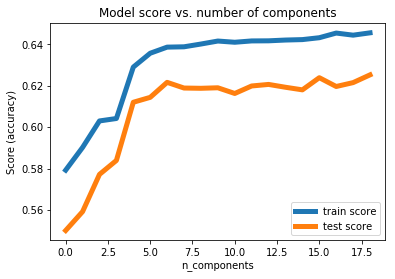

In [704]:
plt.plot(list(zip(train_scores[1:20], test_scores[1:20])), linewidth=5)
plt.title('Model score vs. number of components')
plt.xlabel('n_components')
plt.ylabel('Score (accuracy)')
plt.legend(['train score', 'test score'], loc='best')

In [705]:
pca_transformer.explained_variance_ratio_.cumsum()

array([0.35211773, 0.43025616, 0.47743884, 0.51540716, 0.55063205,
       0.57980551, 0.60161763, 0.62276734, 0.64263677, 0.66177181,
       0.67886498, 0.69551356, 0.7104849 , 0.72445063, 0.7380419 ,
       0.75065726, 0.76254088, 0.77424256, 0.78483297, 0.79468571,
       0.80398771, 0.81320206, 0.82155642, 0.82883374, 0.83599545,
       0.8429198 , 0.84949993, 0.85560125, 0.86153743])

It seems that the best number of components is 6

In [689]:
pca_transformer = PCA(6)
X_train_pca = pca_transformer.fit_transform(X_train)
X_test_pca = pca_transformer.transform(X_test)

In [696]:
print('DT:\n===')
DT_clf = DecisionTreeClassifier(max_depth=20, min_samples_split=100, min_samples_leaf=100)
DT_clf.fit(X_train_pca, y_train)
print('Train:', DT_clf.score(X_train_pca, y_train))
print('Test: ', DT_clf.score(X_test_pca, y_test))

print('\nK-NN:\n=====')
KNN_clf = KNeighborsClassifier(n_neighbors=15)
KNN_clf.fit(X_train_pca, y_train)
print('Train:', KNN_clf.score(X_train_pca, y_train))
print('Test: ', KNN_clf.score(X_test_pca, y_test))

print('\nLR:\n===')
LR_clf = LogisticRegression().fit(X_train_pca, y_train)
print('Train:', LR_clf.score(X_train_pca, y_train))
print('Test: ', LR_clf.score(X_test_pca, y_test))

print('\nSVM:\n====')
SVM_clf = SVC().fit(X_train_pca, y_train)
print('Train:', SVM_clf.score(X_train_pca, y_train))
print('Test: ', SVM_clf.score(X_test_pca, y_test))

DT:
===
Train: 0.6457720489918168
Test:  0.6247816321437485

K-NN:
=====
Train: 0.6590896935337219
Test:  0.6164212627901173

LR:
===
Train: 0.6204203882975878
Test:  0.6166708260544048

SVM:
====
Train: 0.6386586083328877
Test:  0.6303968055902172


## 8. Using Pipeline (with K-NN)

In [712]:
# find best number of components

for n in range (1,20):
    steps = [('reduce_dim', PCA(n)), ('clf', neighbors.KNeighborsClassifier(n_neighbors=15))]
    pipe = Pipeline(steps)    
    pipe.fit(X_train, y_train)
    print(f'results for {n} components: ', 'Train:', pipe.score(X_train, y_train), 'Test:', pipe.score(X_test, y_test))

results for 1 components:  Train: 0.5882227095255923 Test: 0.5319440978287996
results for 2 components:  Train: 0.618387976680751 Test: 0.5673820813576241
results for 3 components:  Train: 0.6265176231480987 Test: 0.5782380833541303
results for 4 components:  Train: 0.6365727121998181 Test: 0.5927127526828051
results for 5 components:  Train: 0.6391934534952132 Test: 0.5907162465685051
results for 6 components:  Train: 0.6559875915922341 Test: 0.6119291240329423
results for 7 components:  Train: 0.6613360432154891 Test: 0.620039930122286
results for 8 components:  Train: 0.6626196716050703 Test: 0.621537309708011
results for 9 components:  Train: 0.6607477135369311 Test: 0.619540803593711
results for 10 components:  Train: 0.6591966625661871 Test: 0.6184177689044172
results for 11 components:  Train: 0.660159383858373 Test: 0.6150486648365361
results for 12 components:  Train: 0.6583409103064662 Test: 0.6159221362615424
results for 13 components:  Train: 0.6614964967641868 Test: 0.6181

Best result with number of components = 8

In [713]:
# find best number of n_neighbors

for k in range (5,20):
    steps = [('reduce_dim', PCA(8)), ('clf', neighbors.KNeighborsClassifier(n_neighbors=k))]
    pipe = Pipeline(steps)    
    pipe.fit(X_train, y_train)
    print(f'results for {k} n_neighbors: ', 'Train:', pipe.score(X_train, y_train), 'Test:', pipe.score(X_test, y_test))

results for 5 n_neighbors:  Train: 0.6883457239129273 Test: 0.5975792363364113
results for 6 n_neighbors:  Train: 0.6850296839065091 Test: 0.6086848015972048
results for 7 n_neighbors:  Train: 0.6794138097020912 Test: 0.6144247566758173
results for 8 n_neighbors:  Train: 0.6770070064716265 Test: 0.6126778138258049
results for 9 n_neighbors:  Train: 0.6752420174359522 Test: 0.6151734464686798
results for 10 n_neighbors:  Train: 0.6712306787185109 Test: 0.6157973546293986
results for 11 n_neighbors:  Train: 0.6695191741990694 Test: 0.6209134015472922
results for 12 n_neighbors:  Train: 0.67016098839386 Test: 0.6186673321687047
results for 13 n_neighbors:  Train: 0.668021607744558 Test: 0.6162964811579735
results for 14 n_neighbors:  Train: 0.6650799593517677 Test: 0.6254055403044672
results for 15 n_neighbors:  Train: 0.6626731561213028 Test: 0.6270277015223359
results for 16 n_neighbors:  Train: 0.6618708883778146 Test: 0.6219116546044422
results for 17 n_neighbors:  Train: 0.6609081670

Best result with number of n_neighbors = 15

## 9. Using Cross Validation (with SVM)

In [725]:
for c in range (1,501,50):
    steps = [('reduce_dim', PCA(8)), ('clf', SVC(C=c))]
    pipe = Pipeline(steps)    
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    print(f'C = {c}: mean={scores.mean()} std={scores.std()}')

C = 1: mean=0.6155523032641212 std=0.00781287517387333
C = 51: mean=0.6364118396030005 std=0.01174148416356297
C = 101: mean=0.6371610032588644 std=0.011184285090547207
C = 151: mean=0.6373209878203334 std=0.01241519720550821
C = 201: mean=0.6379091088038396 std=0.012556083923854752
C = 251: mean=0.6380699513599974 std=0.011803805746531849
C = 301: mean=0.6384976730869051 std=0.010878269501982663
C = 351: mean=0.6388722764178443 std=0.010713713057891263
C = 401: mean=0.6386581867764296 std=0.010527612552631634
C = 451: mean=0.6382840410931419 std=0.01082130414070127


In [726]:
steps = [('reduce_dim', PCA(8)), ('clf', SVC(C=350))]
pipe = Pipeline(steps) 
pipe.fit(X_train, y_train)
print('Train:', pipe.score(X_train, y_train))
print('Test:', pipe.score(X_test, y_test))

Train: 0.6571107664331176
Test: 0.6385076116795607


## 10. Grid Search (with DT)

In [752]:
stop here <<<>>>

SyntaxError: invalid syntax (<ipython-input-752-d81081a57b71>, line 1)

In [734]:
steps = [('reduce_dim', PCA()), ('clf', DecisionTreeClassifier())]
pipe = Pipeline(steps) 

parameters = {
    'reduce_dim__n_components': range (5, 10),
    'clf__max_depth': range(2, 10),
    'clf__min_samples_split': [30, 50, 70, 100],
    'clf__min_samples_leaf': range(10, 110, 10)}

grid_search = GridSearchCV(pipe, parameters, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)
grid_search.score(X_test, y_test)

0.6194041824891694
{'clf__max_depth': 7, 'clf__min_samples_leaf': 50, 'clf__min_samples_split': 70, 'reduce_dim__n_components': 8}


0.6184177689044172

Using these "best parameters" with the "naive" model as shown at the top of the page, will provide better results:

In [748]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)
DT_clf = DecisionTreeClassifier(max_depth=7, min_samples_split=70, min_samples_leaf=50)
DT_clf.fit(X_train, y_train)
print('Train:', DT_clf.score(X_train, y_train))
print('Test: ', DT_clf.score(X_test, y_test))

Train: 0.6497833877092581
Test:  0.6425006239081608


**Best score so far...**


## 11. Using Ensemble methods

### 11.1. Voting

In [754]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
cols = [col for col in list(X.columns) if col != 'Named']
X = pd.get_dummies(X, columns=cols)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

clf1 = KNeighborsClassifier(n_neighbors=8)
clf2 = DecisionTreeClassifier(max_depth=7, min_samples_split=70, min_samples_leaf=50)
clf3 = SVC(350)
clf4 = LogisticRegression()

classifiers = [('KNN', clf1), ('DT', clf2), ('SVM', clf3), ('LR', clf4)]

In [755]:
clf_voting = VotingClassifier(estimators=classifiers, voting='hard')
clf_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')), ('DT', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [757]:
print("{:3} classifier:\n \
    \ttrain accuracy: {:.4f}\n \
    \ttest accuracy: {:.4f}"\
    .format('Voting', 
            clf_voting.score(X_train, y_train), 
            clf_voting.score(X_test, y_test)))
print(classification_report(y_test, clf_voting.predict(X_test)))

Voting classifier:
     	train accuracy: 0.6692
     	test accuracy: 0.6451
                 precision    recall  f1-score   support

       Adoption       0.62      0.89      0.73      3273
           Died       0.00      0.00      0.00        67
     Euthanasia       0.58      0.08      0.14       455
Return_to_owner       0.50      0.39      0.44      1425
       Transfer       0.77      0.60      0.67      2794

    avg / total       0.64      0.65      0.62      8014



**Best score so far! :) **


In [758]:
# Run the above Voting on the original "naive" data

X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)
clf1 = KNeighborsClassifier(n_neighbors=8)
clf2 = DecisionTreeClassifier(max_depth=7, min_samples_split=70, min_samples_leaf=50)
clf3 = SVC(350)
clf4 = LogisticRegression()
classifiers = [('KNN', clf1), ('DT', clf2), ('SVM', clf3), ('LR', clf4)]
clf_voting = VotingClassifier(estimators=classifiers, voting='hard')
clf_voting.fit(X_train, y_train)
print("{:3} classifier:\n \
    \ttrain accuracy: {:.4f}\n \
    \ttest accuracy: {:.4f}"\
    .format('Voting', 
            clf_voting.score(X_train, y_train), 
            clf_voting.score(X_test, y_test)))
print(classification_report(y_test, clf_voting.predict(X_test)))

Voting classifier:
     	train accuracy: 0.6702
     	test accuracy: 0.6442
                 precision    recall  f1-score   support

       Adoption       0.62      0.88      0.73      3273
           Died       0.00      0.00      0.00        67
     Euthanasia       0.59      0.08      0.14       455
Return_to_owner       0.50      0.39      0.44      1425
       Transfer       0.77      0.60      0.67      2794

    avg / total       0.64      0.64      0.62      8014



A bit worse than the earlier one

### 11.2 Random Forest

In [762]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
cols = [col for col in list(X.columns) if col != 'Named']
X = pd.get_dummies(X, columns=cols)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

In [793]:
# using default parameters

RF_clf = RandomForestClassifier(random_state=4014) 
RF_clf.fit(X_train, y_train)

print('Train:', RF_clf.score(X_train, y_train))
print('Test: ', RF_clf.score(X_test, y_test))

Train: 0.8142482751243515
Test:  0.5929623159470926


In [794]:
# using the DT parameters

RF_clf = RandomForestClassifier(max_depth=7, min_samples_split=70, min_samples_leaf=50, random_state=4014) 
RF_clf.fit(X_train, y_train)

print('Train:', RF_clf.score(X_train, y_train))
print('Test: ', RF_clf.score(X_test, y_test))

Train: 0.6155532973204257
Test:  0.6128025954579486


In [795]:
# using other parameters (no fear of overfit)

RF_clf = RandomForestClassifier(max_depth=15, min_samples_split=2, min_samples_leaf=2, random_state=4014) 
RF_clf.fit(X_train, y_train)

print('Train:', RF_clf.score(X_train, y_train))
print('Test: ', RF_clf.score(X_test, y_test))

Train: 0.6772209445365567
Test:  0.6381332667831295


### 11.3. AdaBoost

In [796]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
cols = [col for col in list(X.columns) if col != 'Named']
X = pd.get_dummies(X, columns=cols)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

clf_base = DecisionTreeClassifier(max_depth=3)
clf_adaboost = AdaBoostClassifier(base_estimator=clf_base, n_estimators=200, learning_rate=0.01)
clf_adaboost.fit(X_train, y_train)

print("{:3} classifier:\n \
    \ttrain accuracy: {:.4f}\n \
    \ttest accuracy: {:.4f}"\
    .format('DT ADA boosting', 
            clf_adaboost.score(X_train, y_train), 
            clf_adaboost.score(X_test, y_test)))
print(classification_report(y_test, clf_adaboost.predict(X_test)))

DT ADA boosting classifier:
     	train accuracy: 0.63
     	test accuracy: 0.63
                 precision    recall  f1-score   support

       Adoption       0.59      0.94      0.72      3273
           Died       0.00      0.00      0.00        67
     Euthanasia       0.00      0.00      0.00       455
Return_to_owner       0.48      0.20      0.28      1425
       Transfer       0.76      0.59      0.67      2794

    avg / total       0.59      0.63      0.58      8014



### 11.4. Gradient Boosting

In [797]:
X = outcomes2.drop('OutcomeType', axis=1)
y = outcomes2.OutcomeType
cols = [col for col in list(X.columns) if col != 'Named']
X = pd.get_dummies(X, columns=cols)
X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state=4014)

clf_GB = GradientBoostingClassifier(max_depth=3, n_estimators=200, learning_rate=0.01)
clf_GB.fit(X_train, y_train)

print("{:3} classifier:\n \
    \ttrain accuracy: {:.4f}\n \
    \ttest accuracy: {:.4f}"\
    .format('DT gradient boosting', 
            clf_GB.score(X_train, y_train), 
            clf_GB.score(X_test, y_test)))
print(classification_report(y_test, clf_GB.predict(X_test)))

DT gradient boosting classifier:
     	train accuracy: 0.6433
     	test accuracy: 0.6373
                 precision    recall  f1-score   support

       Adoption       0.64      0.83      0.73      3273
           Died       0.00      0.00      0.00        67
     Euthanasia       0.66      0.05      0.10       455
Return_to_owner       0.47      0.43      0.45      1425
       Transfer       0.72      0.63      0.67      2794

    avg / total       0.63      0.64      0.61      8014



## 12. Summary

Along the way, I've tried to manipulate the data in several ways, especially regarding the features that I've added to the dataset in part1 of the project (dogs features):

- Leaving these features as-is (with values 1-5 and 999 for the missing data)
- Converting the 999 values to median values of each feature
- Filtering out the 999 values
- Categorizing these features

I also tried to apply Scaling were I thought that might improve the result.

In addition, I applied all the classification models that we've learned in the course, trying to find the best hyperparameters for each model.

The best score I've reached - while using the Voting method - was **0.6451** (as shown above, applying the model on the Cats portion of the dataset provided us with a higher score).